In [518]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from cdt.metrics import SHD
from sklearn.metrics import precision_score, recall_score, f1_score





df = pd.read_csv('CNC_Machine.csv')
df_clean = df.drop(columns=["Unnamed: 0", "filename", "start_time", "end_time", "edge", "meterID"])
df_clean.fillna(df_clean.median(), inplace=True)



In [519]:
target = "average_power_consumption"
X = df_clean.drop(columns=[target])
y = df_clean[target]
feature_names = df_clean.columns.tolist()


In [520]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


scaler_y = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()




In [521]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [522]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

In [523]:
class CNCCausalModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.adjacency = nn.Parameter(torch.randn(input_dim, input_dim))  
        nn.init.xavier_uniform_(self.adjacency)  
        
        #Deeper network with more neurons
        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.target_net = nn.Linear(64, 1)

    def forward(self, x):
        # W = torch.tanh(self.adjacency) 
        W = torch.tanh(self.adjacency) * (1 - torch.eye(self.adjacency.shape[0])) 
        masked_input = torch.matmul(x, W)
        shared = self.shared_net(masked_input)
        return self.target_net(shared)


In [524]:
model = CNCCausalModel(X_scaled.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)  
criterion = nn.HuberLoss(delta=1.0)  

In [525]:
# X_tensor = torch.FloatTensor(X_scaled)
# y_tensor = torch.FloatTensor(y_scaled)

In [526]:
for epoch in range(3000):  
    optimizer.zero_grad()
    
    pred = model(X_train_tensor)
    loss = criterion(pred, y_train_tensor)
    
    
    W = torch.sigmoid(model.adjacency)
    h = torch.trace(torch.matrix_exp(W * W)) - W.shape[0]
    loss += 0.1 * h * h  
    
    loss += 0.05 * torch.norm(model.adjacency, p=1)

    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    loss.backward()
    optimizer.step()
    # scheduler.step()

    # if epoch % 500 == 0:
    #     print(f"Epoch {epoch}: Loss={loss.item():.6f}, DAG Loss={h.item():.6f}")


In [527]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    adj_matrix = torch.sigmoid(model.adjacency).numpy()

y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))


In [528]:
print("y mean:", y.mean(), "y std:", y.std())
print("y_scaled mean:", y_scaled.mean(), "y_scaled std:", y_scaled.std())


y mean: 2835.3724582008444 y std: 720.7970690058299
y_scaled mean: 0.457528488253665 y_scaled std: 0.2565619710294054


In [529]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"R²: {r2:.3f}, MAE: {mae:.2f} kW")

R²: 0.920, MAE: 136.04 kW


In [530]:
feature_names = [col for col in df_clean.columns if col != target]
print("Features:", feature_names)
print("Number of features:", len(feature_names))

Features: ['processing_time', 'missing_data', 'raw_volume', 'lines_of_code', 'tool_changes', 'travels_to_zero_point_in_rapid_traverse', 'axes_rotation', 'weighted_rotational_speed', 'weighted_tool_diameter', 'weighted_cutting_length', 'weighted_number_of_cutting_edges', 'weighted_cutting_speed', 'weighted_feed_per_tooth', 'weighted_feed_rate']
Number of features: 14


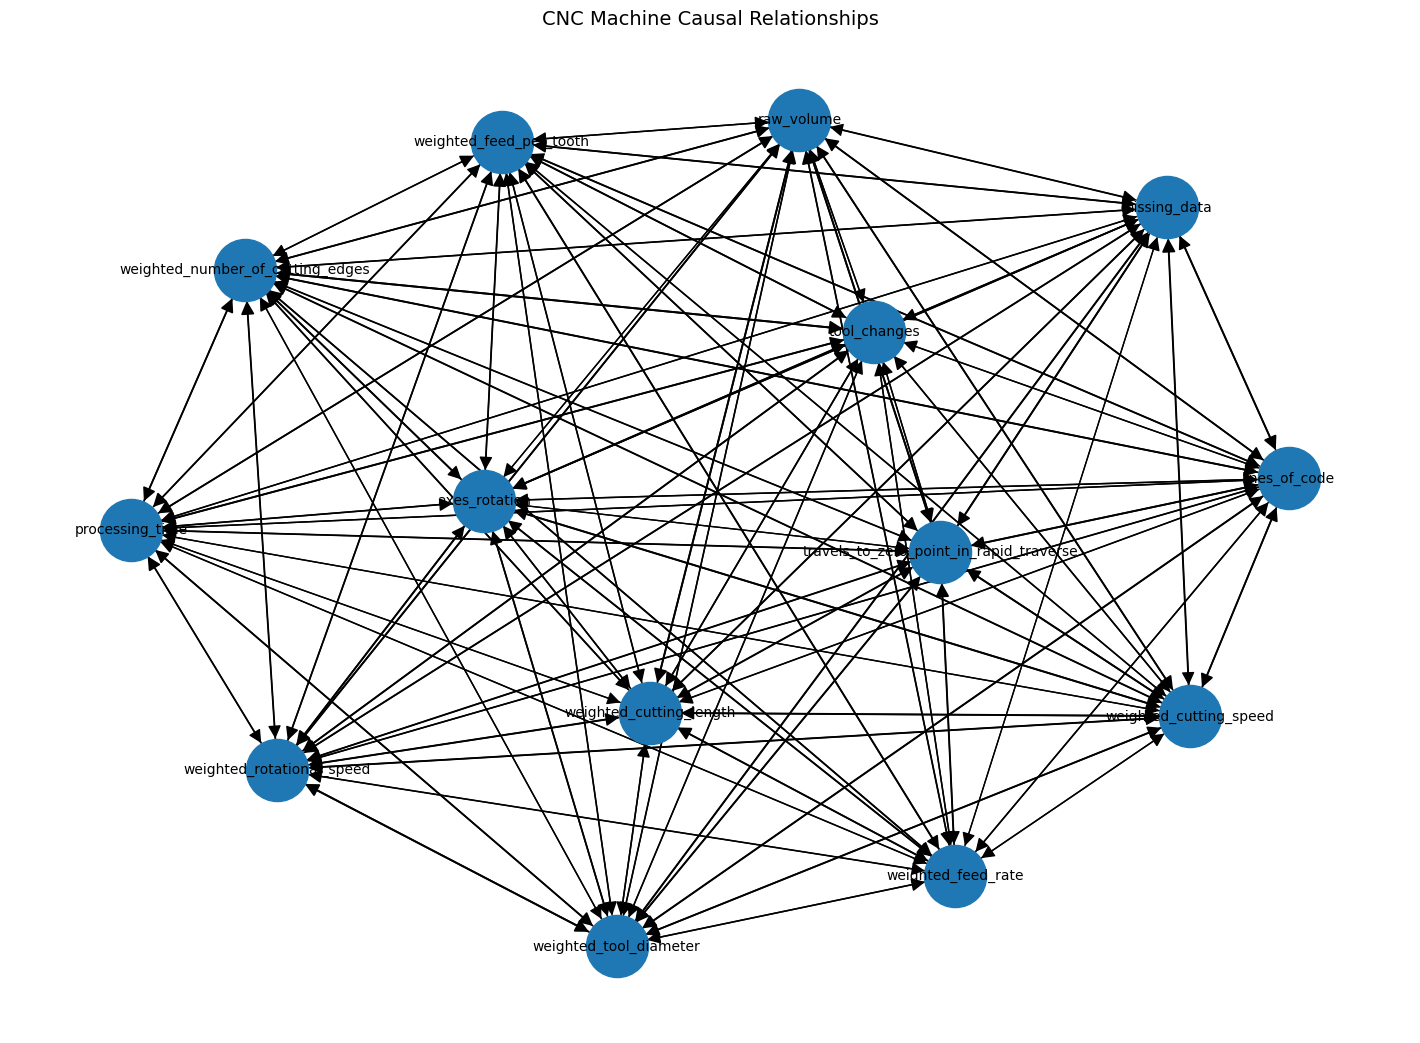

In [531]:
G = nx.DiGraph()
threshold = 0.2 

for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if adj_matrix[i, j] > threshold and i != j:
            G.add_edge(feature_names[i], feature_names[j], weight=adj_matrix[i, j])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.7)
nx.draw(G, pos, with_labels=True, 
        node_size=2000,
        width=[G[u][v]['weight']*3 for u, v in G.edges],
        arrowsize=20,
        font_size=10)
plt.title("CNC Machine Causal Relationships", fontsize=14)
plt.show()

In [532]:
feature_importance = adj_matrix.mean(axis=1)  
results = pd.DataFrame({
    'Feature': feature_names,
    'Causal_Weight': feature_importance
}).sort_values('Causal_Weight', key=abs, ascending=False)

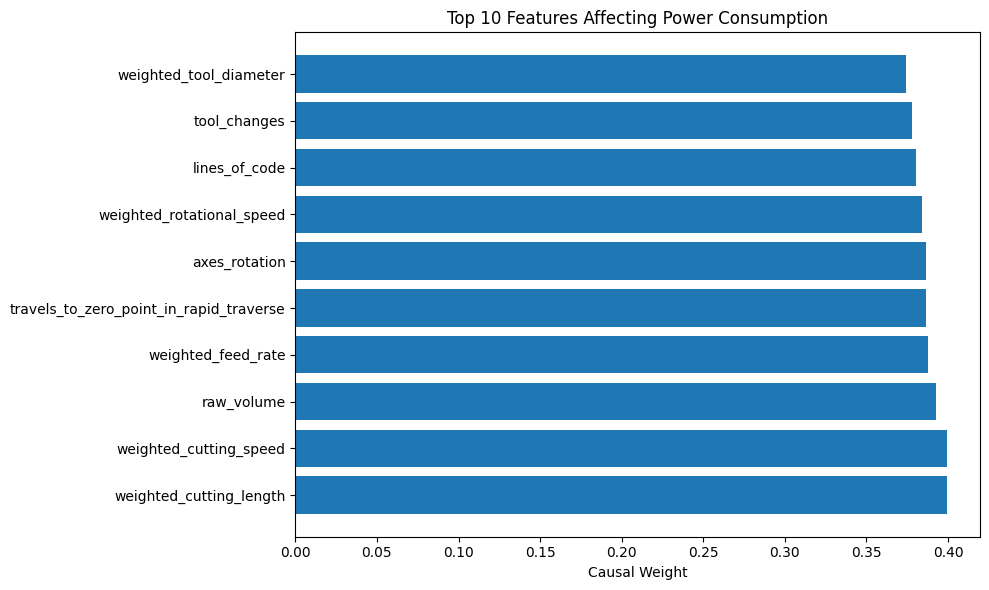

In [533]:
plt.figure(figsize=(10, 6))
plt.barh(results['Feature'].head(10), results['Causal_Weight'].head(10))
plt.xlabel('Causal Weight')
plt.title('Top 10 Features Affecting Power Consumption')
plt.tight_layout()
plt.show()

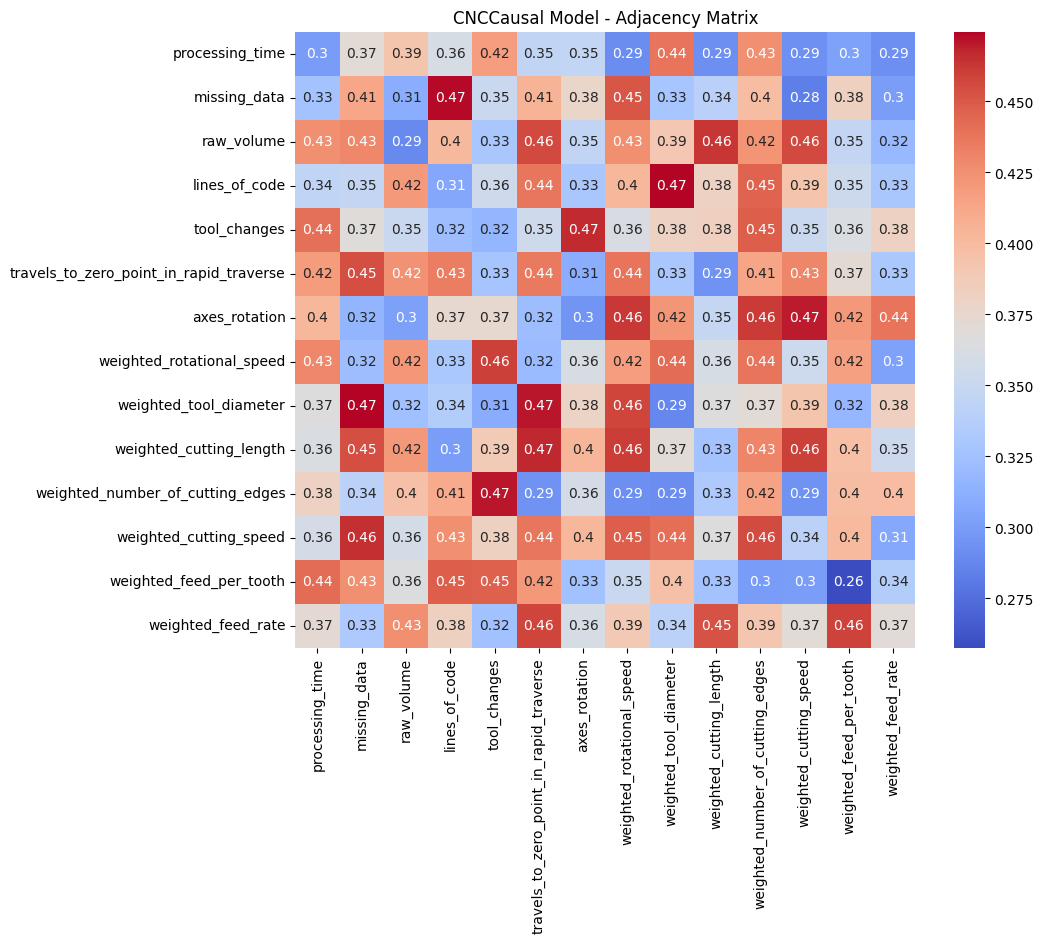

In [534]:
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix, xticklabels=feature_names, yticklabels=feature_names, cmap="coolwarm", annot=True)
plt.title("CNCCausal Model - Adjacency Matrix")
plt.show()

In [535]:
ground_truth_graph = nx.DiGraph([
    ("weighted_cutting_speed", target),
    ("weighted_rotational_speed", target),
    ("processing_time", target)
])

In [536]:
def get_top_k_edges(adj_matrix, feature_names, k=15):  
    edges = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if i != j:
                edges.append((feature_names[i], feature_names[j], adj_matrix[i, j]))
    edges.sort(key=lambda x: x[2], reverse=True)
    return edges[:k]


true_edge_count = len(ground_truth_graph.edges())
top_edges = get_top_k_edges(adj_matrix, feature_names, k=true_edge_count)
# top_edges = get_top_k_edges(adj_matrix, feature_names)
G = nx.DiGraph()
for src, tgt, weight in top_edges:
    G.add_edge(src, tgt, weight=weight)


target = "average_power_consumption"
if target not in G.nodes():
    G.add_node(target)
if target not in ground_truth_graph.nodes():
    ground_truth_graph.add_node(target)


# true_edges = ground_truth_graph.edges()
# pred_edges = G.edges()


In [537]:
def calculate_edge_metrics(true_edges, pred_edges):
    """Compute precision, recall, F1 for edges."""
    true_edges = set(true_edges)
    pred_edges = set(pred_edges)
    
    nodes = sorted(list(set([n for edge in true_edges | pred_edges for n in edge])))
    n = len(nodes)
    true_mat = np.zeros((n, n))
    pred_mat = np.zeros((n, n))
    
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    for src, tgt in true_edges:
        true_mat[node_to_idx[src], node_to_idx[tgt]] = 1
        
    for src, tgt in pred_edges:
        if src in node_to_idx and tgt in node_to_idx:  
            pred_mat[node_to_idx[src], node_to_idx[tgt]] = 1
    
    true_flat = true_mat.flatten()
    pred_flat = pred_mat.flatten()
    
    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)
    
    return precision, recall, f1

true_edges = ground_truth_graph.edges()
pred_edges = G.edges()

precision, recall, f1 = calculate_edge_metrics(true_edges, pred_edges)

common_nodes = set(ground_truth_graph.nodes()) & set(G.nodes())

true_subgraph = ground_truth_graph.subgraph(common_nodes).copy()
pred_subgraph = G.subgraph(common_nodes).copy()

shd_value = SHD(true_subgraph, pred_subgraph)

print("\nCausal Graph Metrics:")
print(f"- Precision: {precision:.3f} (Fraction of predicted edges that are correct)")
print(f"- Recall: {recall:.3f} (Fraction of true edges recovered)")
print(f"- F1: {f1:.3f} (Harmonic mean of precision/recall)")
print(f"- SHD: {shd_value} (Structural Hamming Distance - computed on common nodes only)")

print("\nPredictive Metrics:")
print(f"- R²: {r2_score(y_test_rescaled, y_pred_rescaled):.3f}")
print(f"- MAE: {mean_absolute_error(y_test_rescaled, y_pred_rescaled):.2f} kW")


Causal Graph Metrics:
- Precision: 0.000 (Fraction of predicted edges that are correct)
- Recall: 0.000 (Fraction of true edges recovered)
- F1: 0.000 (Harmonic mean of precision/recall)
- SHD: 0.0 (Structural Hamming Distance - computed on common nodes only)

Predictive Metrics:
- R²: 0.920
- MAE: 136.04 kW


In [538]:
print("\nGround Truth Graph Edges:", list(ground_truth_graph.edges()))
print("\nPredicted Graph Edges:", list(G.edges()))


Ground Truth Graph Edges: [('weighted_cutting_speed', 'average_power_consumption'), ('weighted_rotational_speed', 'average_power_consumption'), ('processing_time', 'average_power_consumption')]

Predicted Graph Edges: [('lines_of_code', 'weighted_tool_diameter'), ('weighted_tool_diameter', 'missing_data'), ('missing_data', 'lines_of_code')]
